# Gaussian Process Regression via Kalman Smoothing

## Import and load data

generating some data ...


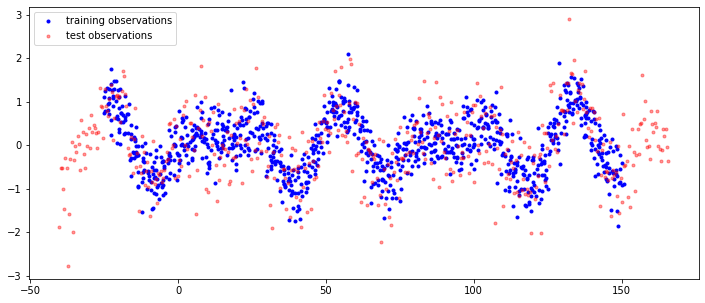

In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
from jax.nn import softplus
from jax.experimental import optimizers
import matplotlib.pyplot as plt
import time
from sde_gp import SDEGP
import approximate_inference as approx_inf
import priors
import likelihoods
from utils import softplus_list, plot
pi = 3.141592653589793


def wiggly_time_series(x_):
    noise_var = 0.15  # true observation noise
    return (np.cos(0.04*x_+0.33*pi) * np.sin(0.2*x_) +
            np.math.sqrt(noise_var) * np.random.normal(0, 1, x_.shape))


plot_intermediate = False

print('generating some data ...')
np.random.seed(12345)
N = 1000
# x = np.linspace(-25.0, 75.0, num=N)  # evenly spaced
x = np.random.permutation(np.linspace(-25.0, 150.0, num=N) + 0.5*np.random.randn(N))  # unevenly spaced
y = wiggly_time_series(x)
x_test = np.linspace(np.min(x)-15.0, np.max(x)+15.0, num=500)
y_test = wiggly_time_series(x_test)

plt.figure(1, figsize=(12, 5))
plt.plot(x, y, 'b.', label='training observations')
plt.plot(x_test, y_test, 'r.', alpha=0.4, label='test observations')
plt.legend();

## Build the GP model

In [2]:
var_f = 1.0  # GP variance
len_f = 5.0  # GP lengthscale
var_y = 0.5  # observation noise

prior = priors.Matern52(variance=var_f, lengthscale=len_f)
# prior_ = priors.QuasiPeriodicMatern32([var_f, len_f, 20., 50.])
lik = likelihoods.Gaussian(variance=var_y)
inf_method = approx_inf.EP(power=0.5)
# inf_method = approx_inf.EKS()
# inf_method = approx_inf.EEP()
# inf_method = approx_inf.VI()

model = SDEGP(prior=prior, likelihood=lik, t=x, y=y, t_test=x_test, y_test=y_test, approx_inf=inf_method)

/Users/wilkinw1/Library/Python/3.7/lib/python/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


building SDE-GP with Matern-5/2 prior and Gaussian likelihood ...
inference method is Expectation Propagation (EP)


## Set up the optimiser

In [3]:
opt_init, opt_update, get_params = optimizers.adam(step_size=5e-1)
# parameters should be a 2-element list [param_prior, param_likelihood]
opt_state = opt_init([model.prior.hyp, model.likelihood.hyp])


def gradient_step(i, state, mod):
    params = get_params(state)
    mod.prior.hyp = params[0]
    mod.likelihood.hyp = params[1]

    # grad(Filter) + Smoother:
    neg_log_marg_lik, gradients = mod.run()
    # neg_log_marg_lik, gradients = mod.run_two_stage()  # <-- less elegant but reduces compile time

    prior_params, lik_param = softplus_list(params[0]), softplus(params[1])
    if (i % 10) == 0:
        print('iter %2d: var_f=%1.2f len_f=%1.2f var_y=%1.2f, nlml=%2.2f' %
              (i, prior_params[0], prior_params[1], lik_param, neg_log_marg_lik))

    if plot_intermediate:
        plot(mod, i)

    return opt_update(i, gradients, state)

## Optimise the hyperparameters and site parameters

In [4]:
print('optimising the hyperparameters ...')
t0 = time.time()
for j in range(200):
    opt_state = gradient_step(j, opt_state, model)
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))

optimising the hyperparameters ...
iter  0: var_f=1.00 len_f=5.00 var_y=0.50, nlml=797.76
iter 10: var_f=0.26 len_f=8.50 var_y=0.19, nlml=536.86
iter 20: var_f=0.56 len_f=10.08 var_y=0.12, nlml=535.47
iter 30: var_f=0.48 len_f=11.31 var_y=0.19, nlml=536.32
iter 40: var_f=0.76 len_f=11.38 var_y=0.13, nlml=529.96
iter 50: var_f=0.57 len_f=11.69 var_y=0.15, nlml=526.24
iter 60: var_f=0.64 len_f=11.46 var_y=0.16, nlml=526.28
iter 70: var_f=0.63 len_f=11.29 var_y=0.15, nlml=526.07
iter 80: var_f=0.56 len_f=11.22 var_y=0.15, nlml=525.98
iter 90: var_f=0.57 len_f=11.11 var_y=0.15, nlml=525.94
iter 100: var_f=0.57 len_f=11.07 var_y=0.15, nlml=525.95
iter 110: var_f=0.57 len_f=11.08 var_y=0.15, nlml=525.94
iter 120: var_f=0.57 len_f=11.09 var_y=0.15, nlml=525.94
iter 130: var_f=0.57 len_f=11.10 var_y=0.15, nlml=525.94
iter 140: var_f=0.57 len_f=11.10 var_y=0.15, nlml=525.94
iter 150: var_f=0.57 len_f=11.11 var_y=0.15, nlml=525.94
iter 160: var_f=0.57 len_f=11.10 var_y=0.15, nlml=525.94
iter 170

## Make predictions

In [5]:
print('calculating the posterior predictive distribution ...')
t0 = time.time()
posterior_mean, posterior_cov, _, nlpd = model.predict()
t1 = time.time()
print('prediction time: %2.2f secs' % (t1-t0))
print('test NLPD: %1.2f' % nlpd)

calculating the posterior predictive distribution ...
prediction time: 1.16 secs
test NLPD: 1.27


## Sample from the posterior distribution

In [6]:
print('sampling from the posterior ...')
t0 = time.time()
posterior_samp = model.posterior_sample(20)
t1 = time.time()
print('sampling time: %2.2f secs' % (t1-t0))

sampling from the posterior ...
sampling time: 3.69 secs


## Plot the posterior

plotting ...


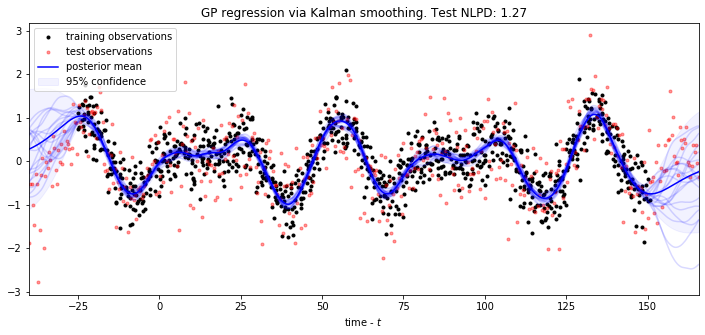

In [7]:
lb = posterior_mean[:, 0, 0] - 1.96 * posterior_cov[:, 0, 0] ** 0.5
ub = posterior_mean[:, 0, 0] + 1.96 * posterior_cov[:, 0, 0] ** 0.5
x_pred = model.t_all[:, 0]
test_id = model.test_id
t_test = model.t_all[test_id]

print('plotting ...')
plt.figure(2, figsize=(12, 5))
plt.clf()
plt.plot(x, y, 'k.', label='training observations')
plt.plot(x_test, y_test, 'r.', alpha=0.4, label='test observations')
plt.plot(x_pred, posterior_mean[..., 0], 'b', label='posterior mean')
plt.fill_between(x_pred, lb, ub, color='b', alpha=0.05, label='95% confidence')
plt.plot(t_test, posterior_samp[test_id, 0, :], 'b', alpha=0.15)
plt.xlim([t_test[0], t_test[-1]])
plt.legend()
plt.title('GP regression via Kalman smoothing. Test NLPD: %1.2f' % nlpd)
plt.xlabel('time - $t$');